# Importing the libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from utils import data_prep, plotting, data_segregate
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Reading the dataset

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [3]:
df_train.head(2)

,Date,Weather,Year,Month,Hour,Holiday,Normalized_Temperature,Normalized_Feeling_Temperature,Normalized_Humidity,Windspeed,Count_of_Casual_Users,Count_of_Registered_Users,Count_of_Rented_Bikes
0,17/12/13,"Clear, Few clouds, Partly cloudy",2013,12,14,0,0.281667,0.269267,0.453371,0.363818,30,207,237
1,28/02/14,"Clear, Few clouds, Partly cloudy",2014,2,21,0,0.350000,0.353500,0.461124,0.110118,10,179,189


In [4]:
df_test.head(2)

,Date,Weather,Year,Month,Hour,Holiday,Normalized_Temperature,Normalized_Feeling_Temperature,Normalized_Humidity,Windspeed
0,08/08/14,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",2014,8,14,0,0.80250,0.742956,0.522247,0.257071
1,27/07/14,"Clear, Few clouds, Partly cloudy",2014,7,20,0,0.78125,0.749067,0.593371,0.105624


# 2. Data Cleaning

In [5]:
# Getting datetime column for train and test data
df_train = data_prep.prepare_datetime(df_train)
df_test = data_prep.prepare_datetime(df_test)

In [6]:
# Selecting a subset of columns
train_cols = ["Date", "datetime"] + ["Weather"] + df_train.columns.tolist()[5:-1]
test_cols = ["Date", "datetime"] + ["Weather"] + df_test.columns.tolist()[5:-1]

df_train_sub = df_train[train_cols]
df_test_sub = df_test[test_cols]

In [7]:
# Sorting the data by datetime
df_train_srtd = df_train_sub.sort_values(by=["datetime"]).reset_index(drop=True)
df_test_srtd = df_test_sub.sort_values(by=["datetime"]).reset_index(drop=True)

In [8]:
df_train_srtd.head()

,Date,datetime,Weather,Holiday,Normalized_Temperature,Normalized_Feeling_Temperature,Normalized_Humidity,Windspeed,Count_of_Casual_Users,Count_of_Registered_Users,Count_of_Rented_Bikes
0,2013-01-01,2013-01-01 00:00:00,"Clear, Few clouds, Partly cloudy",0,0.242083,0.297900,0.815618,0.000337,3,13,16
1,2013-01-01,2013-01-01 01:00:00,"Clear, Few clouds, Partly cloudy",0,0.222083,0.281589,0.807865,0.011236,8,32,40
2,2013-01-01,2013-01-01 03:00:00,"Clear, Few clouds, Partly cloudy",0,0.248750,0.288456,0.752247,0.010112,3,11,14
3,2013-01-01,2013-01-01 04:00:00,"Clear, Few clouds, Partly cloudy",0,0.246250,0.303456,0.758989,0.001124,0,2,2
4,2013-01-01,2013-01-01 05:00:00,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0,0.246250,0.265933,0.757865,0.098589,0,2,2


In [9]:
df_test_srtd.head()

,Date,datetime,Weather,Holiday,Normalized_Temperature,Normalized_Feeling_Temperature,Normalized_Humidity,Windspeed
0,2013-01-01,2013-01-01 02:00:00,"Clear, Few clouds, Partly cloudy",0,0.232500,0.280478,0.806742,0.011236
1,2013-01-01,2013-01-01 08:00:00,"Clear, Few clouds, Partly cloudy",0,0.246667,0.290122,0.751124,0.001124
2,2013-01-01,2013-01-01 14:00:00,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0,0.467083,0.468389,0.721124,0.284724
3,2013-01-01,2013-01-01 17:00:00,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0,0.443750,0.456067,0.826742,0.288094
4,2013-01-01,2013-01-01 18:00:00,"Light Snow, Light Rain + Thunderstorm + Scatte...",0,0.432083,0.436422,0.891236,0.262689


In [10]:
df_train_srtd["datetime"].min(), df_train_srtd["datetime"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2014-12-31 22:00:00'))

In [11]:
df_test_srtd["datetime"].min(), df_test_srtd["datetime"].max()

(Timestamp('2013-01-01 02:00:00'), Timestamp('2014-12-31 23:00:00'))

## Observation

* The training data is available from Jan 1, 2013 - Dec 31, 2014 and it is at hourly granularity
* The missing intermediate timestamps belongs to test dataset

## Problem statement

We need to predict the number of bikes rented in the timestamps available in the test data

# 3. Descriptive analysis

## 3.1 Dataset shape

In [12]:
print(f"There are {df_train_srtd.shape[0]} rows in train data")
print(f"There are {df_test_srtd.shape[0]} rows in test data")

There are 12165 rows in train data
There are 5214 rows in test data


## 3.2 Validating dtypes

In [13]:
df_train_srtd.dtypes

Date                              datetime64[ns]
datetime                          datetime64[ns]
Weather                                   object
Holiday                                    int64
Normalized_Temperature                   float64
Normalized_Feeling_Temperature           float64
Normalized_Humidity                      float64
Windspeed                                float64
Count_of_Casual_Users                      int64
Count_of_Registered_Users                  int64
Count_of_Rented_Bikes                      int64
dtype: object

In [14]:
df_test_srtd.dtypes

Date                              datetime64[ns]
datetime                          datetime64[ns]
Weather                                   object
Holiday                                    int64
Normalized_Temperature                   float64
Normalized_Feeling_Temperature           float64
Normalized_Humidity                      float64
Windspeed                                float64
dtype: object

**Observation:** The data types of the columns in both the dataset is correct

## 3.3 Checking for missing values

In [15]:
df_train_srtd.isna().sum()

Date                              0
datetime                          0
Weather                           0
Holiday                           0
Normalized_Temperature            0
Normalized_Feeling_Temperature    0
Normalized_Humidity               0
Windspeed                         0
Count_of_Casual_Users             0
Count_of_Registered_Users         0
Count_of_Rented_Bikes             0
dtype: int64

In [16]:
df_test_srtd.isna().sum()

Date                              0
datetime                          0
Weather                           0
Holiday                           0
Normalized_Temperature            0
Normalized_Feeling_Temperature    0
Normalized_Humidity               0
Windspeed                         0
dtype: int64

**Observation:** There are no missing values in the train and test data

## 3.4 Distribution of values

### i. Count of values

In [17]:
# Count of different weather conditions
df_train_srtd["Weather"].value_counts()

Weather
Clear, Few clouds, Partly cloudy                                                           8032
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                               3140
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds     990
Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                    3
Name: count, dtype: int64

**Observation:**

* `Clear, Few clouds, Partly cloudy` weather has occurred maximum time followed by `Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist`

### ii. Plotting histogram

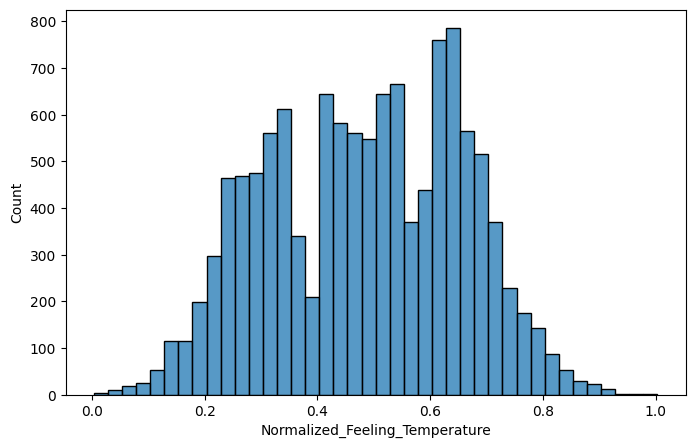

In [18]:
plotting.show_hist(df=df_train_srtd, x_axis="Normalized_Feeling_Temperature")

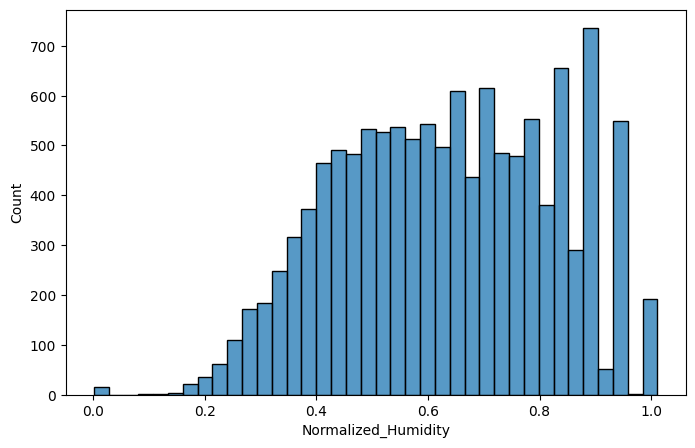

In [19]:
plotting.show_hist(df=df_train_srtd, x_axis="Normalized_Humidity")

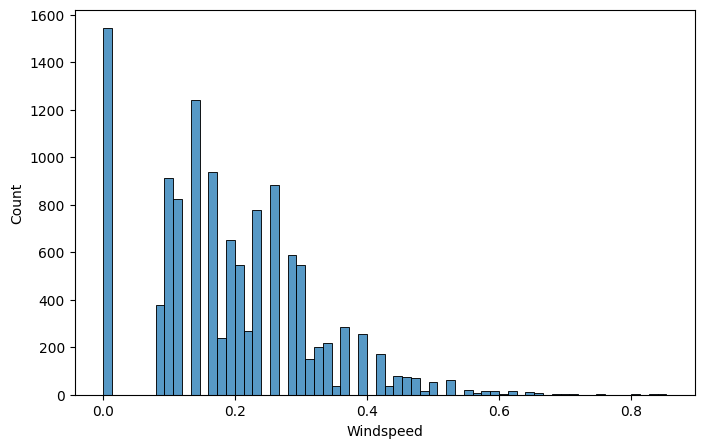

In [20]:
plotting.show_hist(df=df_train_srtd, x_axis="Windspeed")

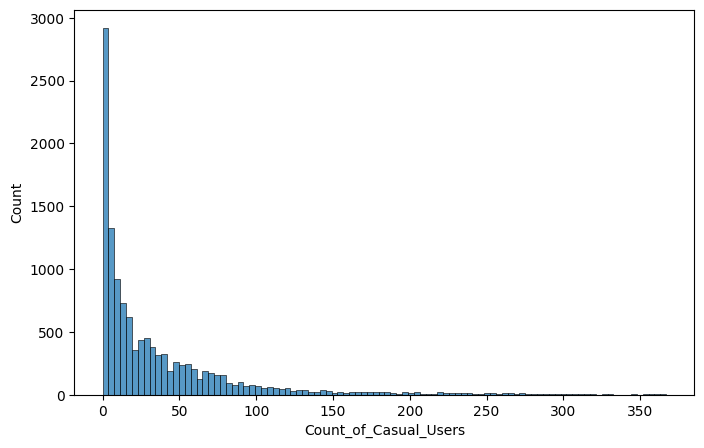

In [21]:
plotting.show_hist(df=df_train_srtd, x_axis="Count_of_Casual_Users")

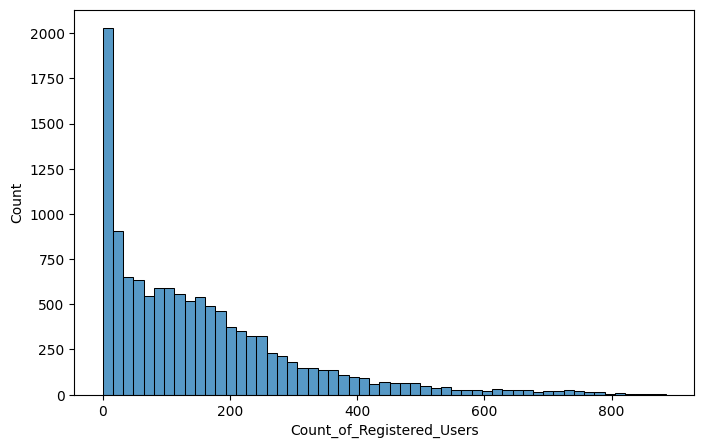

In [22]:
plotting.show_hist(df=df_train_srtd, x_axis="Count_of_Registered_Users")

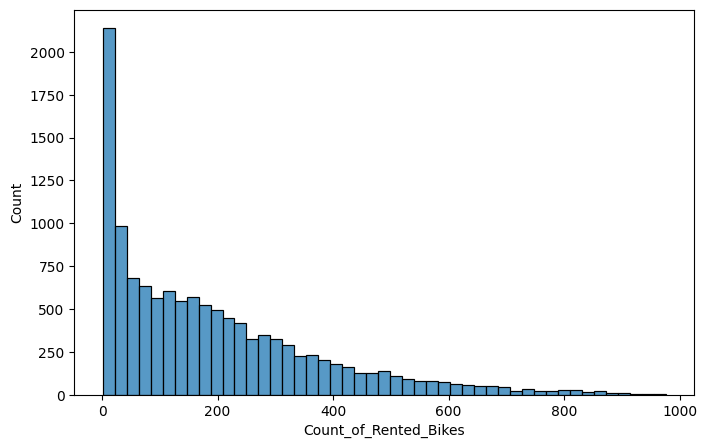

In [23]:
plotting.show_hist(df=df_train_srtd, x_axis="Count_of_Rented_Bikes")

**Observation:**

* The collected data has humidity on a higher side while the windspeed is on a lower side
* The above scenario can lead to feeling temperature on a bit higher side

## 3.4 Summarizing the train dataset

In [24]:
df_train_srtd.describe()

,Date,datetime,Holiday,Normalized_Temperature,Normalized_Feeling_Temperature,Normalized_Humidity,Windspeed,Count_of_Casual_Users,Count_of_Registered_Users,Count_of_Rented_Bikes
count,12165,12165,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000
mean,2014-01-02 01:48:54.155363840,2014-01-02 13:19:05.252774400,0.028442,0.502845,0.483966,0.632797,0.195148,35.304644,154.582244,189.886889
min,2013-01-01 00:00:00,2013-01-01 00:00:00,0.000000,0.023333,0.003333,0.001124,0.000000,0.000000,0.000000,1.000000
25%,2013-07-05 00:00:00,2013-07-05 10:00:00,0.000000,0.344583,0.338300,0.481236,0.110118,4.000000,35.000000,41.000000
50%,2014-01-02 00:00:00,2014-01-02 16:00:00,0.000000,0.508333,0.494800,0.634494,0.194000,17.000000,116.000000,144.000000
75%,2014-07-01 00:00:00,2014-07-01 05:00:00,0.000000,0.660833,0.627311,0.788989,0.263812,48.000000,221.000000,282.000000
max,2014-12-31 00:00:00,2014-12-31 22:00:00,1.000000,1.002083,1.003333,1.011236,0.854071,367.000000,886.000000,977.000000
std,NaN,NaN,0.166239,0.192616,0.172008,0.192051,0.122673,48.787590,151.463431,180.770096


## 3.5 Correlation between features

In [25]:
numerical_cols = data_segregate.get_nmrcl_cols(df_train_srtd)

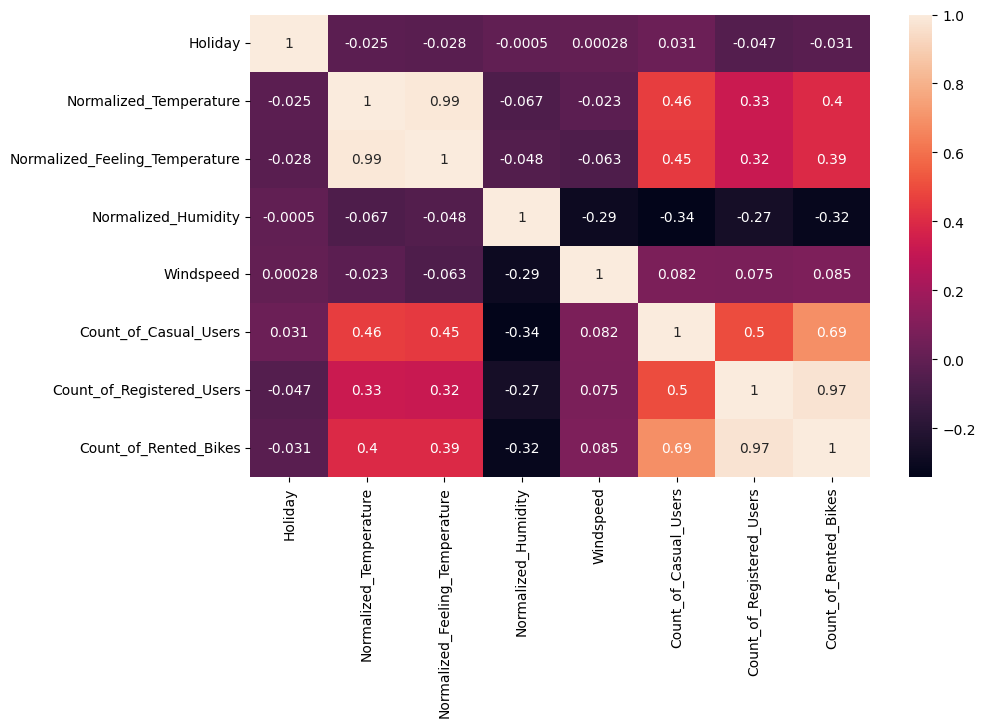

In [26]:
plotting.show_heatmap(df_train_srtd, numerical_cols)

**Observation:**

* It is obvious that `Normalized_Temperature` and `Normalized_Feeling_Temperature` has high correlation. In general, feeling temperature has more significance than the actual temperature.

* `Count_of_Rented_Bikes` is highly dependent on `Count_of_Registered_Users`

## 3.6 Univariate time series analysis

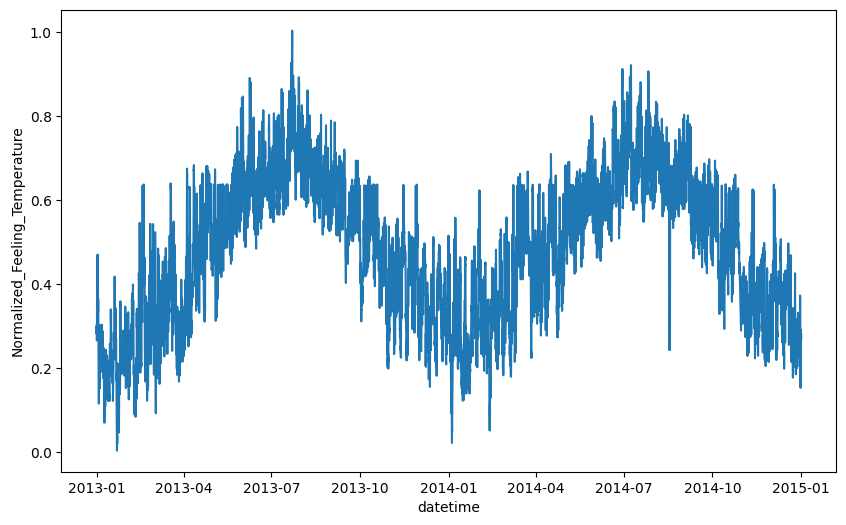

In [27]:
plotting.show_time_series(df=df_train_srtd, x_axis="datetime", y_axis="Normalized_Feeling_Temperature")

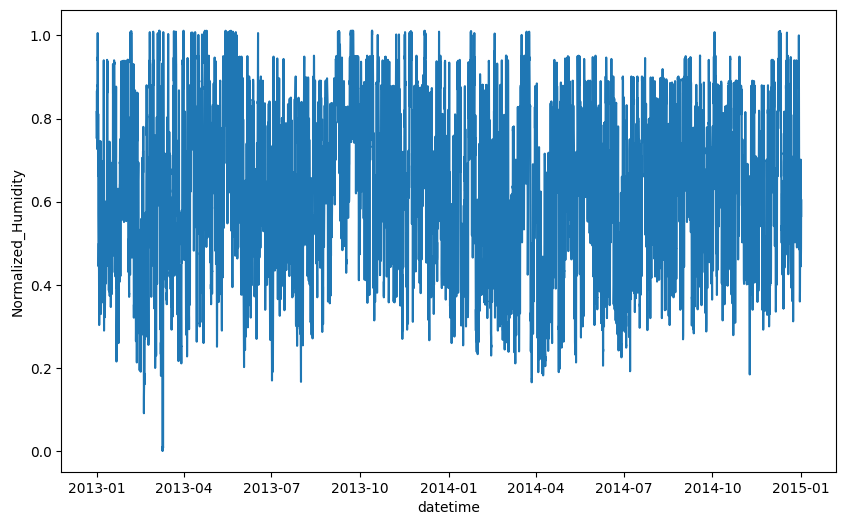

In [28]:
plotting.show_time_series(df=df_train_srtd, x_axis="datetime", y_axis="Normalized_Humidity")

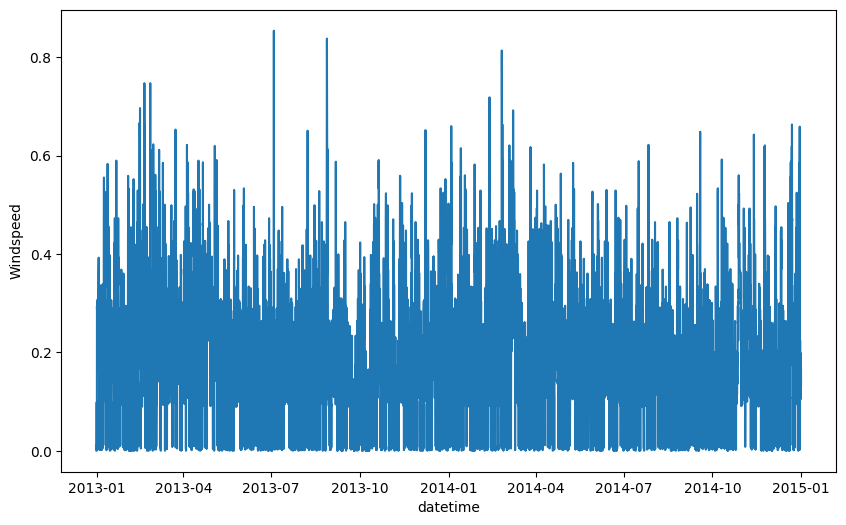

In [29]:
plotting.show_time_series(df=df_train_srtd, x_axis="datetime", y_axis="Windspeed")

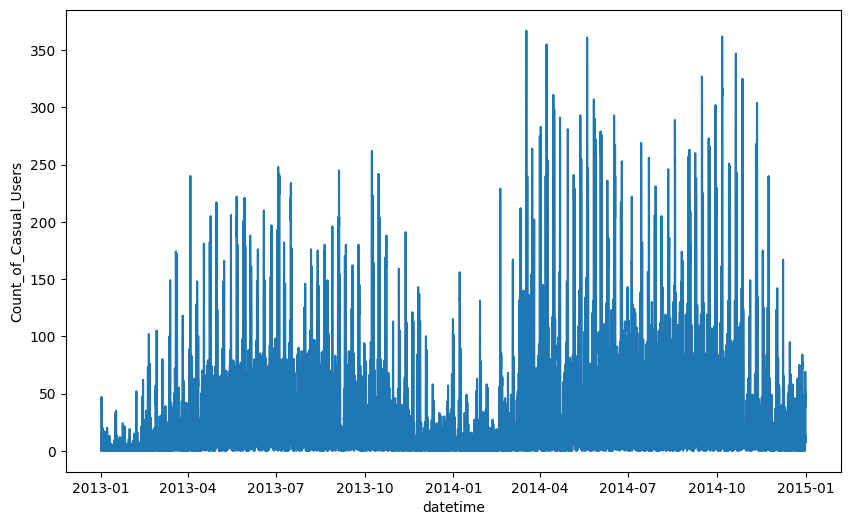

In [30]:
plotting.show_time_series(df=df_train_srtd, x_axis="datetime", y_axis="Count_of_Casual_Users")

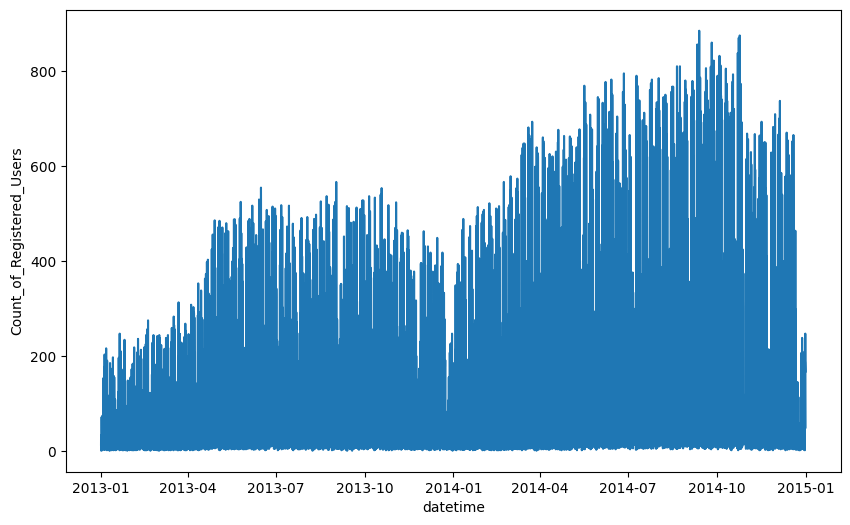

In [31]:
plotting.show_time_series(df=df_train_srtd, x_axis="datetime", y_axis="Count_of_Registered_Users")

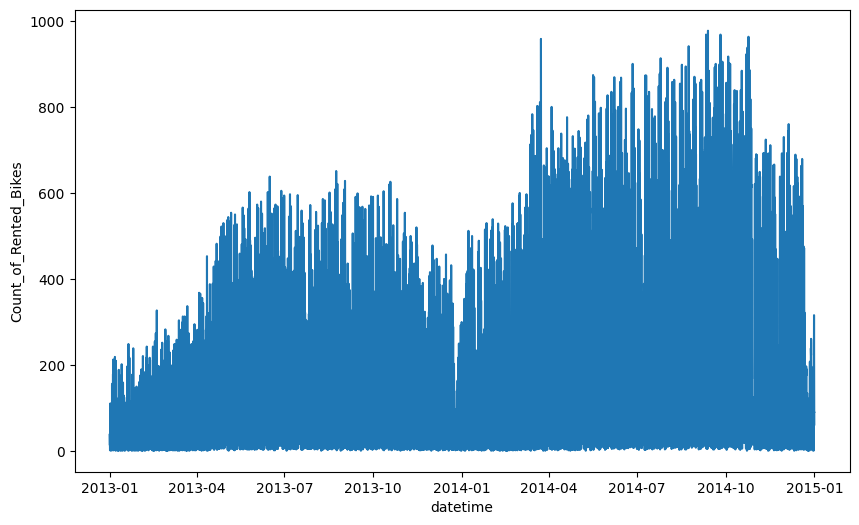

In [32]:
plotting.show_time_series(df=df_train_srtd, x_axis="datetime", y_axis="Count_of_Rented_Bikes")

**Observation:**

* `Count_of_Rented_Bikes` has increased over time